[*********************100%%**********************]  1 of 1 completed


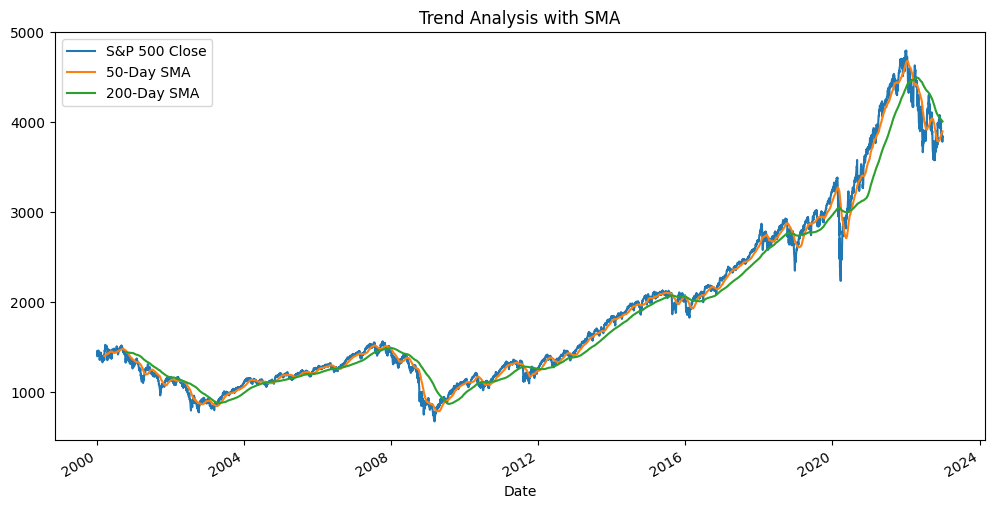

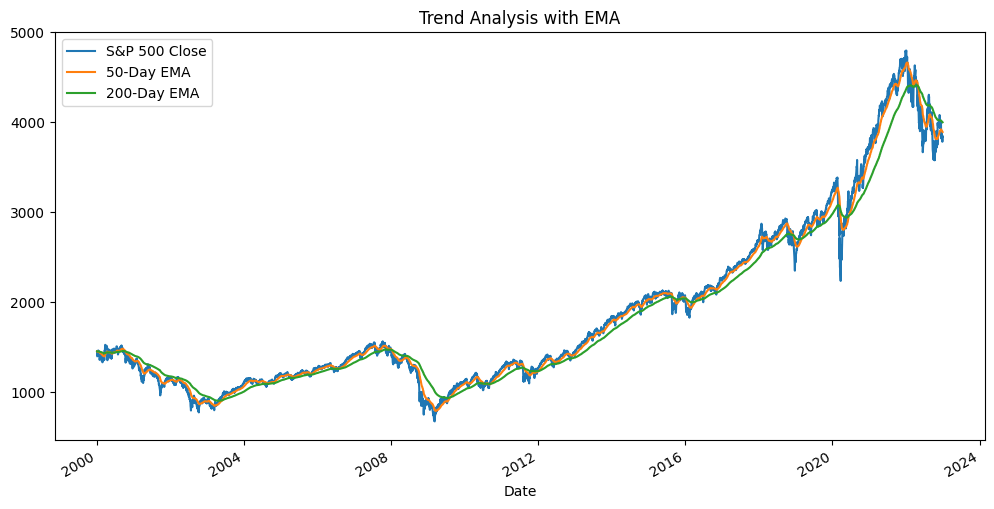

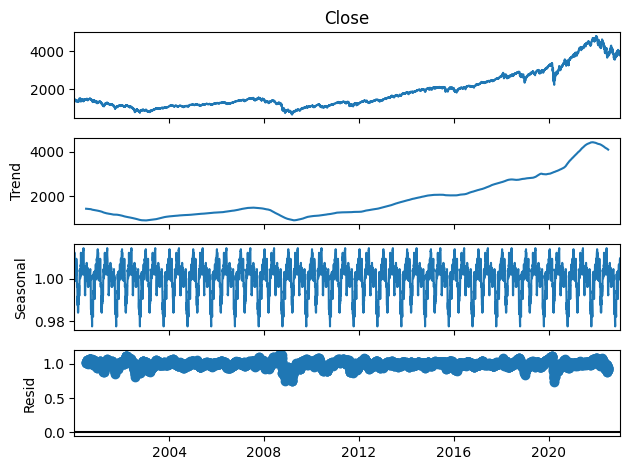

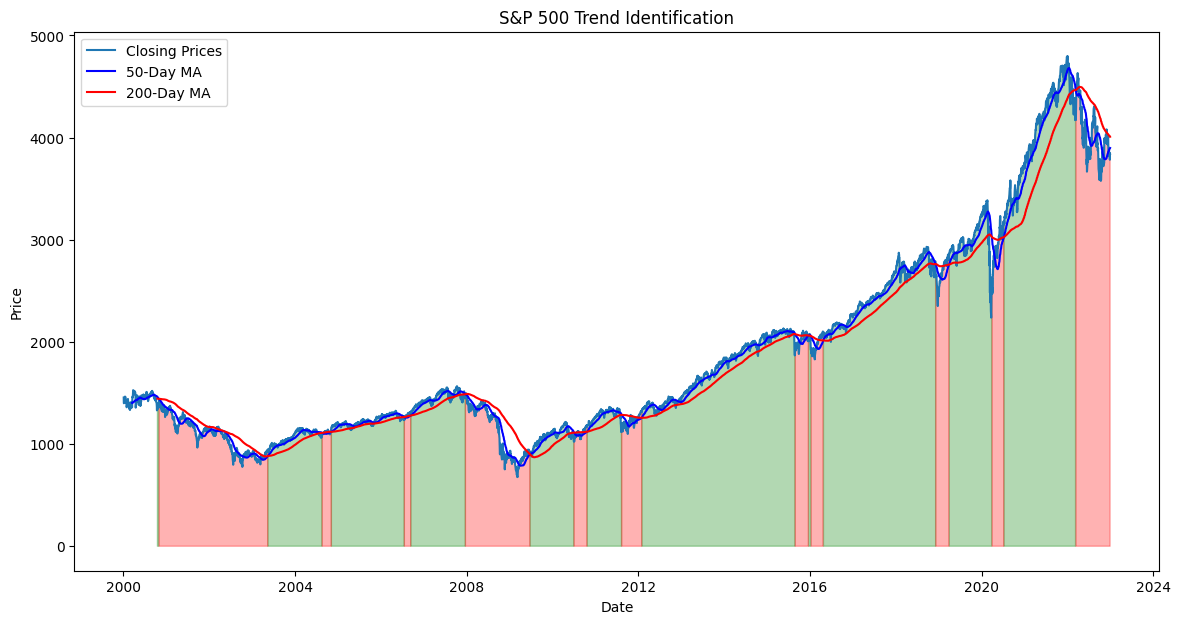

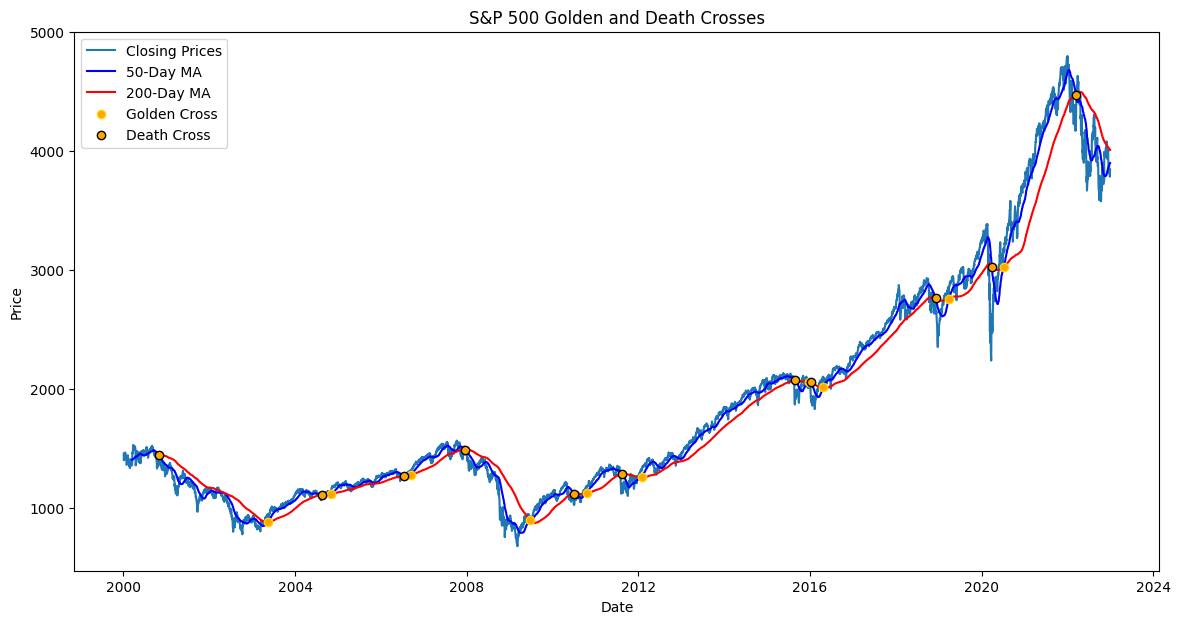

Statistics for periods above 50 EMA:
1. Maximum number of days: 136
2. Average number of days: 21.86
3. Median number of days: 11.0
4. Minimum % change: 0.14%
5. Maximum % change: 26.19%
6. Median % change: 2.76%
7. Average % change: 4.42%
----------------------------------------
Statistics for periods below 50 EMA:
1. Maximum number of days: 86
2. Average number of days: 12.77
3. Median number of days: 5.0
4. Minimum % change: -0.16%
5. Maximum % change: -41.63%
6. Median % change: -2.58%
7. Average % change: -4.55%
----------------------------------------
Statistics for periods above 200 EMA:
1. Maximum number of days: 477
2. Average number of days: 53.53
3. Median number of days: 6.0
4. Minimum % change: 0.14%
5. Maximum % change: 63.10%
6. Median % change: 2.39%
7. Average % change: 6.80%
----------------------------------------
Statistics for periods below 200 EMA:
1. Maximum number of days: 274
2. Average number of days: 25.31
3. Median number of days: 5.5
4. Minimum % change: -0

In [15]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

# Retrieve S&P 500 data
sp500_data = yf.download('^GSPC', start='2000-01-01', end='2023-01-01')

# Let's focus on the 'Close' column for trend analysis
closing_prices = sp500_data['Close']

# Calculate the 50-day and 200-day SMAs
sma50 = closing_prices.rolling(window=50).mean()
sma200 = closing_prices.rolling(window=200).mean()

# Plotting
plt.figure(figsize=(12,6))
closing_prices.plot(label='S&P 500 Close')
sma50.plot(label='50-Day SMA')
sma200.plot(label='200-Day SMA')
plt.legend()
plt.title('Trend Analysis with SMA')
plt.show()

# Calculate the 50-day and 200-day EMAs
ema50 = closing_prices.ewm(span=50, adjust=False).mean()
ema200 = closing_prices.ewm(span=200, adjust=False).mean()

# Plotting
plt.figure(figsize=(12,6))
closing_prices.plot(label='S&P 500 Close')
ema50.plot(label='50-Day EMA')
ema200.plot(label='200-Day EMA')
plt.legend()
plt.title('Trend Analysis with EMA')
plt.show()

# Decompose to retrieve trend, seasonal, and residual components
result = seasonal_decompose(closing_prices, model='multiplicative', period=252)
result.plot()
plt.show()

################################################################################
# Trend identification:

# Using the same DataFrame 'sp500_data' for the trend identification
# Calculate the 50-day and 200-day moving averages
sp500_data['50_MA'] = closing_prices.rolling(window=50).mean()
sp500_data['200_MA'] = closing_prices.rolling(window=200).mean()

# Plotting Trend Identification
plt.figure(figsize=(14,7))
plt.plot(sp500_data['Close'], label='Closing Prices')
plt.plot(sp500_data['50_MA'], label='50-Day MA', color='blue')
plt.plot(sp500_data['200_MA'], label='200-Day MA', color='red')

# Highlighting bullish or bearish zones
sp500_data['Bullish'] = np.where(sp500_data['50_MA'] > sp500_data['200_MA'], sp500_data['Close'], np.nan)
sp500_data['Bearish'] = np.where(sp500_data['50_MA'] < sp500_data['200_MA'], sp500_data['Close'], np.nan)

plt.fill_between(sp500_data.index, sp500_data['Bullish'], color='green', alpha=0.3)
plt.fill_between(sp500_data.index, sp500_data['Bearish'], color='red', alpha=0.3)

plt.title('S&P 500 Trend Identification')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(loc='best')
plt.show()

# Golden and Death Crosses Plot
plt.figure(figsize=(14,7))
plt.plot(sp500_data['Close'], label='Closing Prices')
plt.plot(sp500_data['50_MA'], label='50-Day MA', color='blue')
plt.plot(sp500_data['200_MA'], label='200-Day MA', color='red')

# Identify golden cross and death cross
golden_crosses = ((sp500_data['50_MA'] > sp500_data['200_MA']) & (sp500_data['50_MA'].shift(1) <= sp500_data['200_MA'].shift(1)))
death_crosses = ((sp500_data['50_MA'] < sp500_data['200_MA']) & (sp500_data['50_MA'].shift(1) >= sp500_data['200_MA'].shift(1)))

# Mark golden crosses and death crosses with orange circles
plt.scatter(sp500_data[golden_crosses].index, sp500_data['200_MA'][golden_crosses], color='orange', edgecolors='gold', label='Golden Cross', zorder=5)
plt.scatter(sp500_data[death_crosses].index, sp500_data['200_MA'][death_crosses], color='orange', edgecolors='black', label='Death Cross', zorder=5)

plt.title('S&P 500 Golden and Death Crosses')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(loc='best')
plt.show()

###########################################################################################
#statistics:

def compute_statistics(closing_prices, moving_avg, condition="above"):
    if condition == "above":
        periods = (closing_prices > moving_avg).astype(int)
    else:
        periods = (closing_prices < moving_avg).astype(int)
    
    periods = (periods != periods.shift()).cumsum() * periods
    periods = periods[periods != 0]
    days_counts = periods.value_counts()
    days_counts = days_counts[days_counts > 1]

    max_days = days_counts.max()
    avg_days = days_counts.mean()
    median_days = days_counts.median()

    percent_changes = []
    for period_num, days_count in days_counts.items():
        start_date = periods[periods == period_num].index[0]
        end_date = periods[periods == period_num].index[-1]

        start_value = moving_avg[start_date]
        if condition == "above":
            max_price_during_period = closing_prices[start_date:end_date].max()
        else:
            max_price_during_period = closing_prices[start_date:end_date].min()

        percent_change = ((max_price_during_period - start_value) / start_value) * 100
        percent_changes.append(percent_change)

    if condition == "below":
        min_percent_change, max_percent_change = max(percent_changes), min(percent_changes)
    else:
        min_percent_change, max_percent_change = min(percent_changes), max(percent_changes)

    avg_percent_change = sum(percent_changes) / len(percent_changes)
    median_percent_change = sorted(percent_changes)[len(percent_changes) // 2]

    return max_days, avg_days, median_days, min_percent_change, max_percent_change, median_percent_change, avg_percent_change

conditions = {
    "above 50 EMA": ema50,
    "below 50 EMA": ema50,
    "above 200 EMA": ema200,
    "below 200 EMA": ema200,
    "above 50 SMA": sma50,
    "below 50 SMA": sma50,
    "above 200 SMA": sma200,
    "below 200 SMA": sma200
}

for condition_name, moving_avg in conditions.items():
    if "above" in condition_name:
        cond = "above"
    else:
        cond = "below"
    max_days, avg_days, median_days, min_percent_change, max_percent_change, median_percent_change, avg_percent_change = compute_statistics(closing_prices, moving_avg, cond)

    print(f"Statistics for periods {condition_name}:")
    print(f"1. Maximum number of days: {max_days}")
    print(f"2. Average number of days: {avg_days:.2f}")
    print(f"3. Median number of days: {median_days}")
    print(f"4. Minimum % change: {min_percent_change:.2f}%")
    print(f"5. Maximum % change: {max_percent_change:.2f}%")
    print(f"6. Median % change: {median_percent_change:.2f}%")
    print(f"7. Average % change: {avg_percent_change:.2f}%")
    print("-"*40)



######################################
# golden cross and death cross

def compute_cross_statistics(prices, ma50, ma200, cross_type="golden"):
    golden_crosses = ((ma50 > ma200) & (ma50.shift(1) <= ma200.shift(1)))
    death_crosses = ((ma50 < ma200) & (ma50.shift(1) >= ma200.shift(1)))

    if cross_type == "golden":
        cross_dates = prices[golden_crosses].index
    elif cross_type == "death":
        cross_dates = prices[death_crosses].index

    all_cross_dates = prices[golden_crosses | death_crosses].index

    durations = []
    percent_changes = []
    opposite_changes = []

    for idx, start_date in enumerate(cross_dates[:-1]):
        end_date = all_cross_dates[all_cross_dates.get_loc(start_date) + 1]
        start_price = prices[start_date]

        if cross_type == "golden":
            max_price_during_period = prices[start_date:end_date].max()
            declines = [(start_price - price) / start_price * 100 for price in prices[start_date:end_date]]
            max_decline = min(declines)
            opposite_changes.append(max_decline)
        else:  # death cross
            max_price_during_period = prices[start_date:end_date].min()
            gains = [(price - start_price) / start_price * 100 for price in prices[start_date:end_date]]
            max_gain = max(gains)
            opposite_changes.append(max_gain)

        duration = (prices[start_date:end_date].index[-1] - start_date).days
        percent_change = ((max_price_during_period - start_price) / start_price) * 100

        durations.append(duration)
        percent_changes.append(percent_change)

    max_duration = max(durations)
    avg_duration = sum(durations) / len(durations)
    median_duration = sorted(durations)[len(durations) // 2]
    min_percent_change = min(percent_changes)
    max_percent_change = max(percent_changes)
    avg_percent_change = sum(percent_changes) / len(percent_changes)
    median_percent_change = sorted(percent_changes)[len(percent_changes) // 2]
    
    max_opposite_change = max(opposite_changes)

    return max_duration, avg_duration, median_duration, min_percent_change, max_percent_change, median_percent_change, avg_percent_change, max_opposite_change




# For Golden Crosses
max_duration, avg_duration, median_duration, min_percent_change, max_percent_change, median_percent_change, avg_percent_change, max_opposite_change = compute_cross_statistics(sp500_data['Close'], sp500_data['50_MA'], sp500_data['200_MA'], "golden")

print("Statistics for Golden Crosses:")
print(f"1. Maximum duration between a Golden Cross and next Cross (Golden/Death): {max_duration} days")
print(f"2. Average duration between a Golden Cross and next Cross (Golden/Death): {avg_duration:.2f} days")
print(f"3. Median duration between a Golden Cross and next Cross (Golden/Death): {median_duration} days")
print(f"4. Minimum % change between a Golden Cross and peak price before next Cross: {min_percent_change:.2f}%")
print(f"5. Maximum % change between a Golden Cross and peak price before next Cross: {max_percent_change:.2f}%")
print(f"6. Median % change between a Golden Cross and peak price before next Cross: {median_percent_change:.2f}%")
print(f"7. Average % change between a Golden Cross and peak price before next Cross: {avg_percent_change:.2f}%")
print(f"8. Maximum % decline after a Golden Cross before the next Cross: {max_opposite_change:.2f}%")
print("-"*40)

# For Death Crosses
max_duration, avg_duration, median_duration, min_percent_change, max_percent_change, median_percent_change, avg_percent_change, max_opposite_change = compute_cross_statistics(sp500_data['Close'], sp500_data['50_MA'], sp500_data['200_MA'], "death")

print("Statistics for Death Crosses:")
print(f"1. Maximum duration between a Death Cross and next Cross (Golden/Death): {max_duration} days")
print(f"2. Average duration between a Death Cross and next Cross (Golden/Death): {avg_duration:.2f} days")
print(f"3. Median duration between a Death Cross and next Cross (Golden/Death): {median_duration} days")
print(f"4. Maximum % decline between a Death Cross and minimum price before next Cross: {min_percent_change:.2f}%")
print(f"5. Minimum % decline between a Death Cross and minimum price before next Cross: {max_percent_change:.2f}%")
print(f"6. Median % decline between a Death Cross and minimum price before next Cross: {median_percent_change:.2f}%")
print(f"7. Average % decline between a Death Cross and minimum price before next Cross: {avg_percent_change:.2f}%")
print(f"8. Maximum % gain after a Death Cross before the next Cross: {max_opposite_change:.2f}%")
print("-"*40)

#####################################################################################################
#checking the lagging of golden cross and death cross:

def max_percent_changes_before_crosses(prices, ma50, ma200):
    golden_crosses = ((ma50 > ma200) & (ma50.shift(1) <= ma200.shift(1)))
    death_crosses = ((ma50 < ma200) & (ma50.shift(1) >= ma200.shift(1)))

    golden_cross_dates = prices[golden_crosses].index
    death_cross_dates = prices[death_crosses].index

    max_gain_before_golden = []
    max_loss_before_death = []

    for date in golden_cross_dates:
        month_before = date - pd.Timedelta(days=50)
        max_price = prices[month_before:date].max()
        min_price = prices[month_before:date].min()
        
        percent_gain = ((max_price - min_price) / min_price) * 100
        max_gain_before_golden.append(percent_gain)

    for date in death_cross_dates:
        month_before = date - pd.Timedelta(days=50)
        max_price = prices[month_before:date].max()
        min_price = prices[month_before:date].min()

        percent_loss = ((min_price - max_price) / max_price) * 100
        max_loss_before_death.append(percent_loss)

    return max(max_gain_before_golden), max(max_loss_before_death)

max_gain_golden, max_loss_death = max_percent_changes_before_crosses(sp500_data['Close'], sp500_data['50_MA'], sp500_data['200_MA'])
print("checking the lagging:")
print(f"Maximum % gain before golden crosses: {max_gain_golden:.2f}%")
print(f"Maximum % loss before death crosses: {max_loss_death:.2f}%")



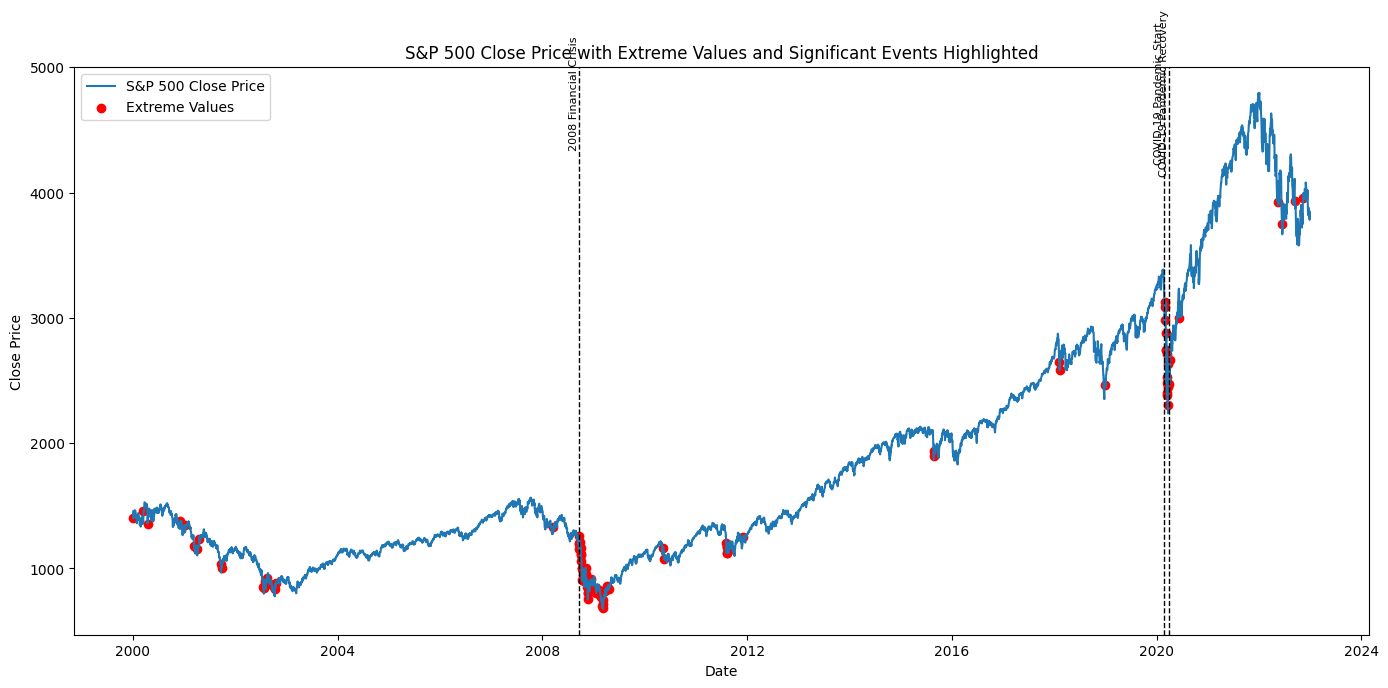

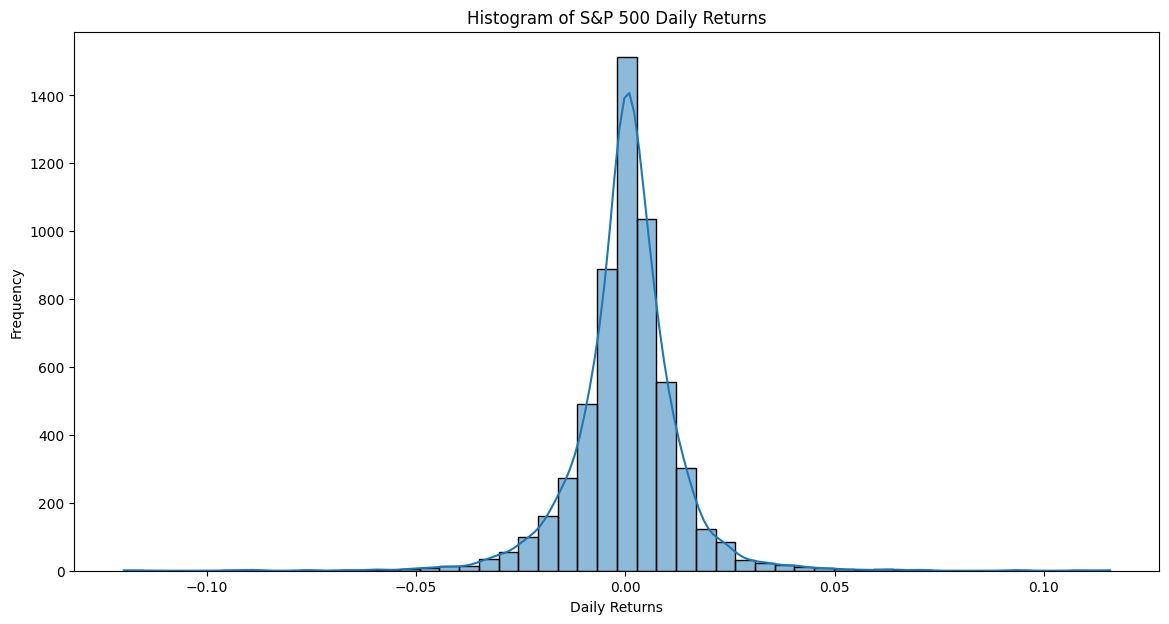

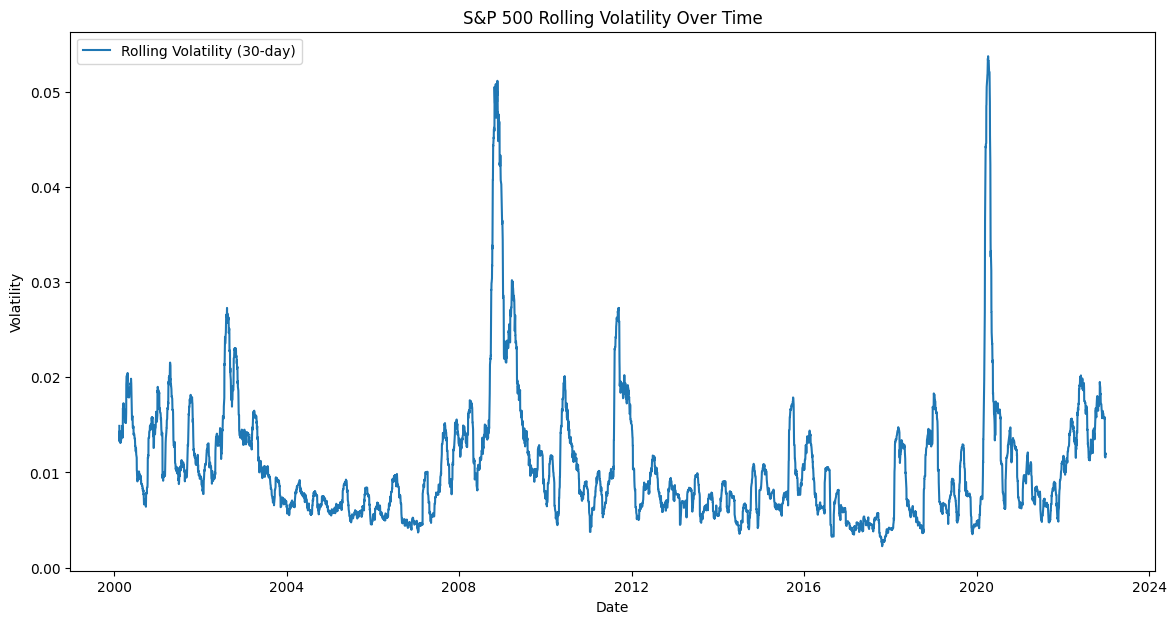

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


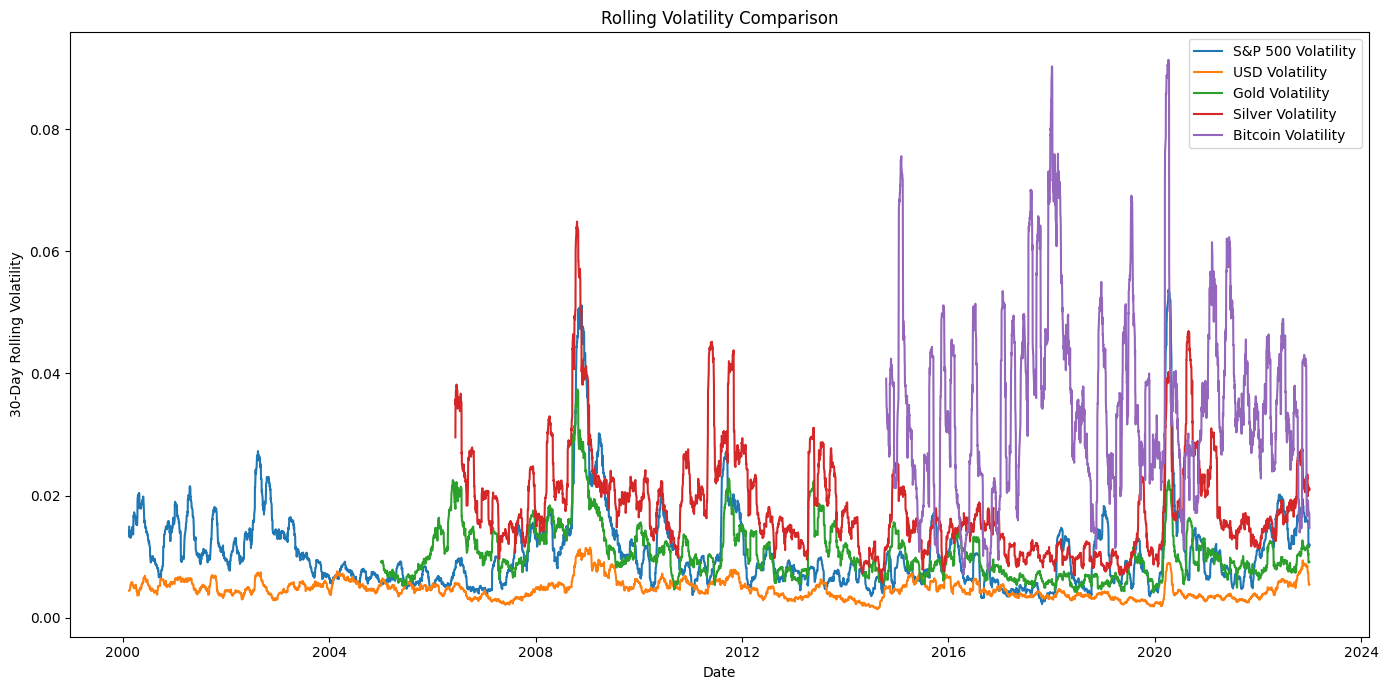


Gold Volatility Ranges:
0-0.02: 95.85%
0.02-0.04: 4.15%
0.04-0.06: 0.00%
0.06+: 0.00%

Silver Volatility Ranges:
0-0.02: 69.27%
0.02-0.04: 27.39%
0.04-0.06: 3.02%
0.06+: 0.31%

Bitcoin Volatility Ranges:
0-0.02: 15.68%
0.02-0.04: 52.43%
0.04-0.06: 24.25%
0.06+: 7.64%

USD Volatility Ranges:
0-0.02: 100.00%
0.02-0.04: 0.00%
0.04-0.06: 0.00%
0.06+: 0.00%

S&P 500 Volatility Ranges:
0-0.02: 94.46%
0.02-0.04: 4.12%
0.04-0.06: 1.42%
0.06+: 0.00%


In [17]:
import seaborn as sns


# Calculate daily returns
sp500_data['Returns'] = sp500_data['Close'].pct_change()

# Calculate the Z-score of the daily returns
sp500_data['Z-Score'] = (sp500_data['Returns'] - sp500_data['Returns'].mean()) / sp500_data['Returns'].std()

# Identify extreme movements
extreme_movements = sp500_data[np.abs(sp500_data['Z-Score']) > 3]

########################################################################

# Calculate the rolling standard deviation of returns over a 30-day window
sp500_data['Rolling_Volatility'] = sp500_data['Returns'].rolling(window=30).std()

# Identify high volatility periods (for example, volatility greater than two times the mean volatility)
high_volatility = sp500_data[sp500_data['Rolling_Volatility'] > 2 * sp500_data['Rolling_Volatility'].mean()]

#########################################################################

# Assume we define a major movement as a movement that is more than 3 standard deviations from the mean
major_movements = sp500_data[np.abs(sp500_data['Z-Score']) > 3]


##########################################################################

# Scatter Plot for Outliers on Top of Line Plot with Event Annotations
plt.figure(figsize=(14, 7))
plt.plot(sp500_data.index, sp500_data['Close'], label='S&P 500 Close Price')

# Highlighting the extreme values
extreme_values = sp500_data['Z-Score'].abs() > 3
plt.scatter(sp500_data.index[extreme_values], sp500_data['Close'][extreme_values], color='red', label='Extreme Values')

# Annotating significant market events
crisis_dates = {
    '2008 Financial Crisis': '2008-09-15',
    'COVID-19 Pandemic Start': '2020-02-20',
    'COVID-19 Pandemic Recovery': '2020-04-01'
}

for event, date in crisis_dates.items():
    plt.axvline(pd.to_datetime(date), color='black', linestyle='--', linewidth=1)
    plt.text(pd.to_datetime(date), sp500_data['Close'].max(), event, 
             rotation=90, verticalalignment='center', fontsize=8, ha='right')

plt.title('S&P 500 Close Price with Extreme Values and Significant Events Highlighted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout() 
plt.show()


# Histogram of Returns
plt.figure(figsize=(14, 7))
sns.histplot(sp500_data['Returns'].dropna(), bins=50, kde=True)
plt.title('Histogram of S&P 500 Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.show()

# Rolling Volatility Over Time
plt.figure(figsize=(14, 7))
plt.plot(sp500_data.index, sp500_data['Rolling_Volatility'], label='Rolling Volatility (30-day)')
plt.title('S&P 500 Rolling Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

##################################################################################

# Define the start and end dates
start_date = "2000-01-01"
end_date = "2023-01-01"

# Define the tickers
dxy_ticker = 'DX-Y.NYB'
gold_ticker = 'GLD'  # Gold ETF
silver_ticker = 'SLV'  # Silver ETF
btc_ticker = 'BTC-USD'  # Bitcoin on Coinbase

# Download historical data within the specified date range
usd_data = yf.download(dxy_ticker, start=start_date, end=end_date)
gold_data = yf.download(gold_ticker, start=start_date, end=end_date)
silver_data = yf.download(silver_ticker, start=start_date, end=end_date)
btc_data = yf.download(btc_ticker, start=start_date, end=end_date)

historical_data = {
    'Gold': gold_data,
    'Silver': silver_data,
    'Bitcoin': btc_data
}

window_size = 30  # 30-day rolling window

sp500_data['SP500_Rolling_Volatility'] = sp500_data['Close'].pct_change().rolling(window=window_size).std()

# Calculate the rolling volatility for USD
usd_data['USD_Rolling_Volatility'] = usd_data['Close'].pct_change().rolling(window=window_size).std()

# Calculate the rolling volatility for Bitcoin, Gold, and Silver
for asset, data in historical_data.items():
    data[f'{asset}_Rolling_Volatility'] = data['Close'].pct_change().rolling(window=window_size).std()

# Plot all the volatilities together
plt.figure(figsize=(14, 7))
plt.plot(sp500_data.index, sp500_data['SP500_Rolling_Volatility'], label='S&P 500 Volatility')
plt.plot(usd_data.index, usd_data['USD_Rolling_Volatility'], label='USD Volatility')

for asset, data in historical_data.items():
    plt.plot(data.index, data[f'{asset}_Rolling_Volatility'], label=f'{asset} Volatility')

plt.title('Rolling Volatility Comparison')
plt.xlabel('Date')
plt.ylabel('30-Day Rolling Volatility')
plt.legend()
plt.tight_layout()
plt.show()

# Define volatility ranges
volatility_ranges = {
    '0-0.02': (0, 0.02),
    '0.02-0.04': (0.02, 0.04),
    '0.04-0.06': (0.04, 0.06),
    '0.06+': (0.06, float('inf'))
}

# Calculate and print the percentages for each volatility range for each asset
all_data = list(historical_data.items()) + [('USD', usd_data)]
for asset, data in all_data:
    print(f"\n{asset} Volatility Ranges:")
    vol_data = data[f'{asset}_Rolling_Volatility'].dropna()
    for label, (low, high) in volatility_ranges.items():
        percentage = ((vol_data >= low) & (vol_data < high)).sum() / len(vol_data) * 100
        print(f"{label}: {percentage:.2f}%")

# Do the same for S&P 500
print("\nS&P 500 Volatility Ranges:")
sp500_vol_data = sp500_data['SP500_Rolling_Volatility'].dropna()
for label, (low, high) in volatility_ranges.items():
    percentage = ((sp500_vol_data >= low) & (sp500_vol_data < high)).sum() / len(sp500_vol_data) * 100
    print(f"{label}: {percentage:.2f}%")


Threshold 1: 1197 extreme values
Threshold 2: 285 extreme values
Threshold 3: 97 extreme values
Threshold 4: 36 extreme values
Threshold 5: 19 extreme values


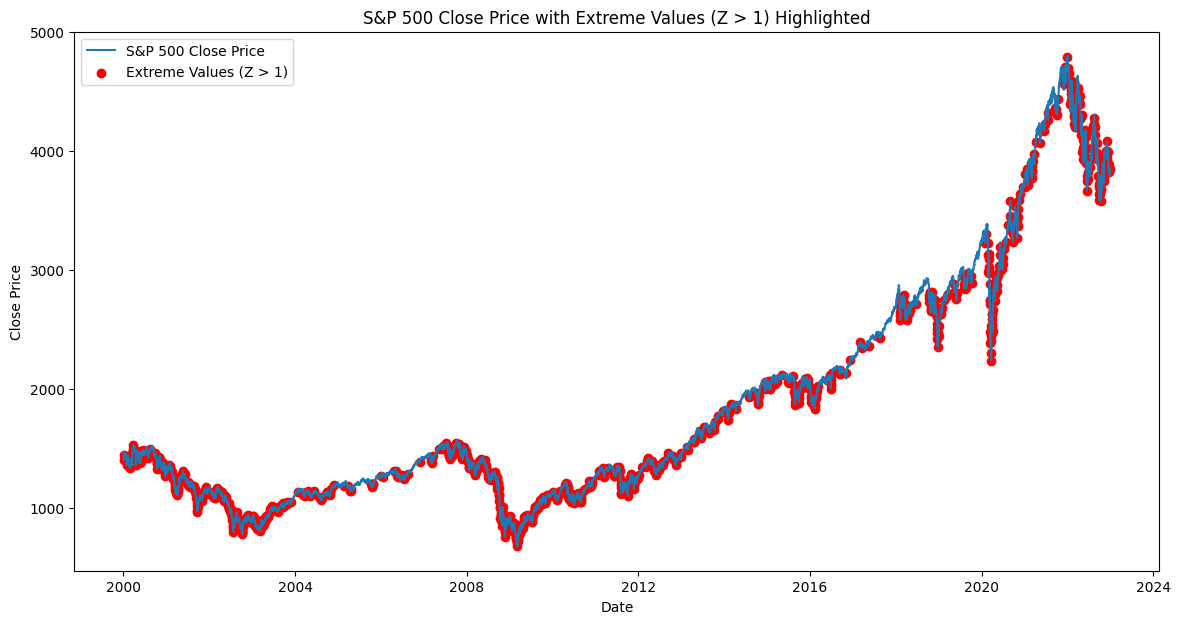

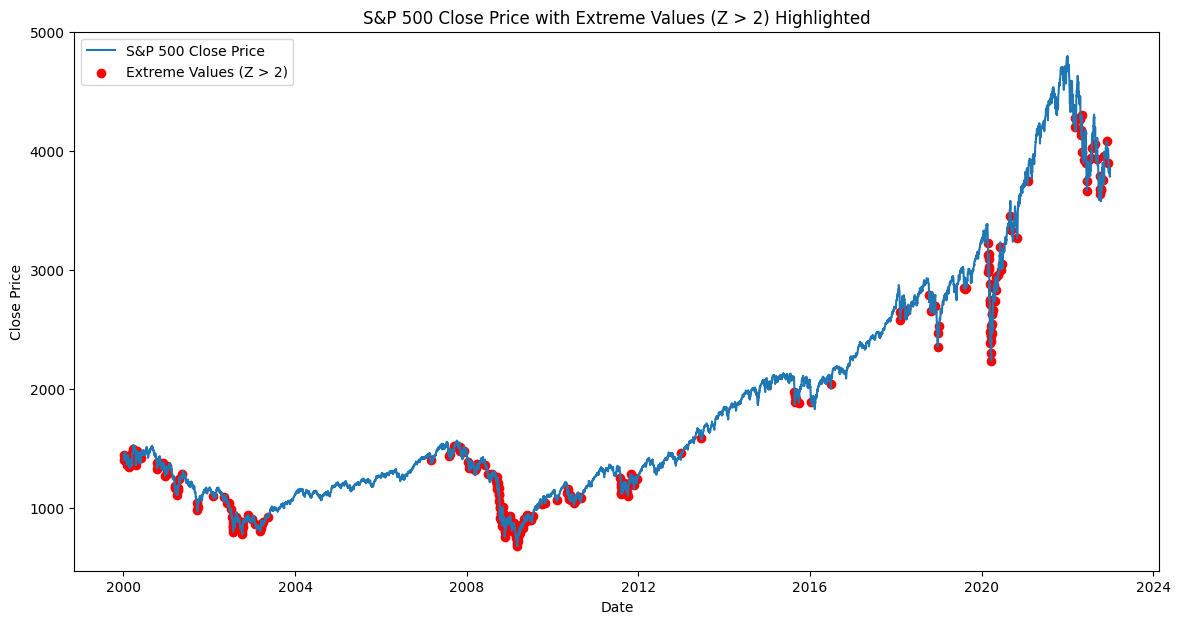

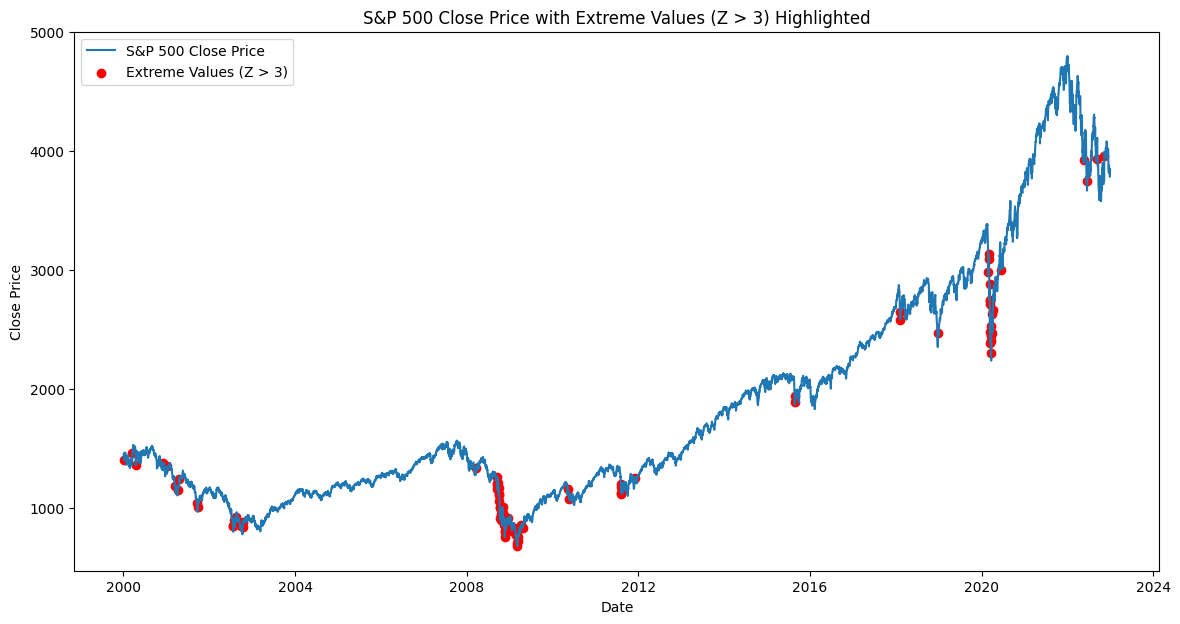

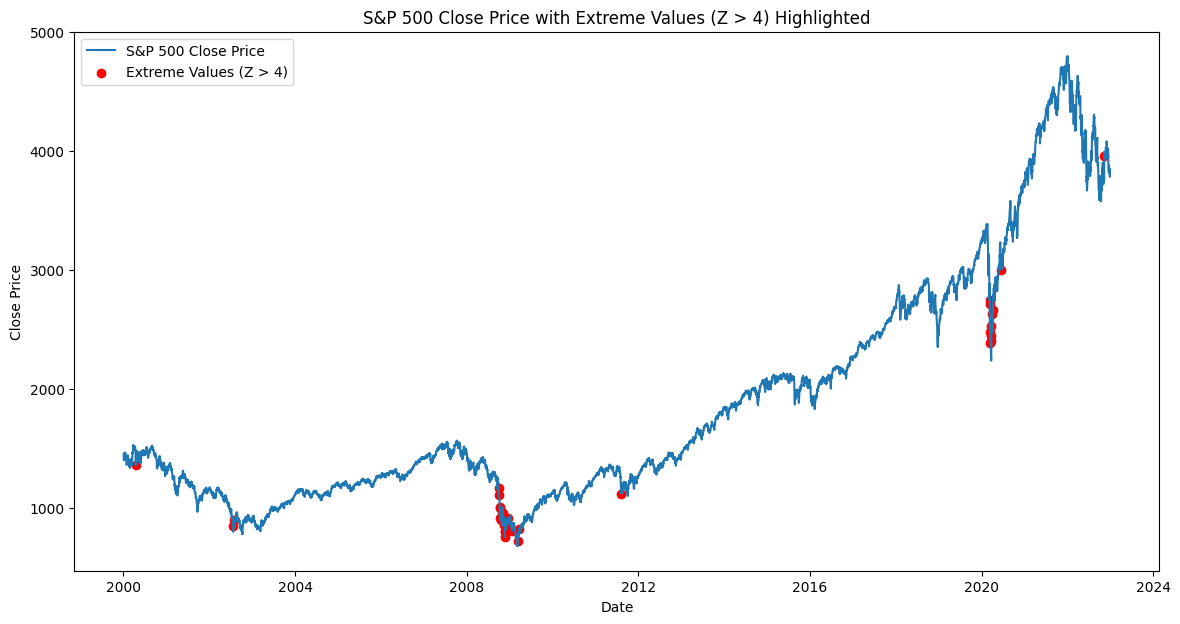

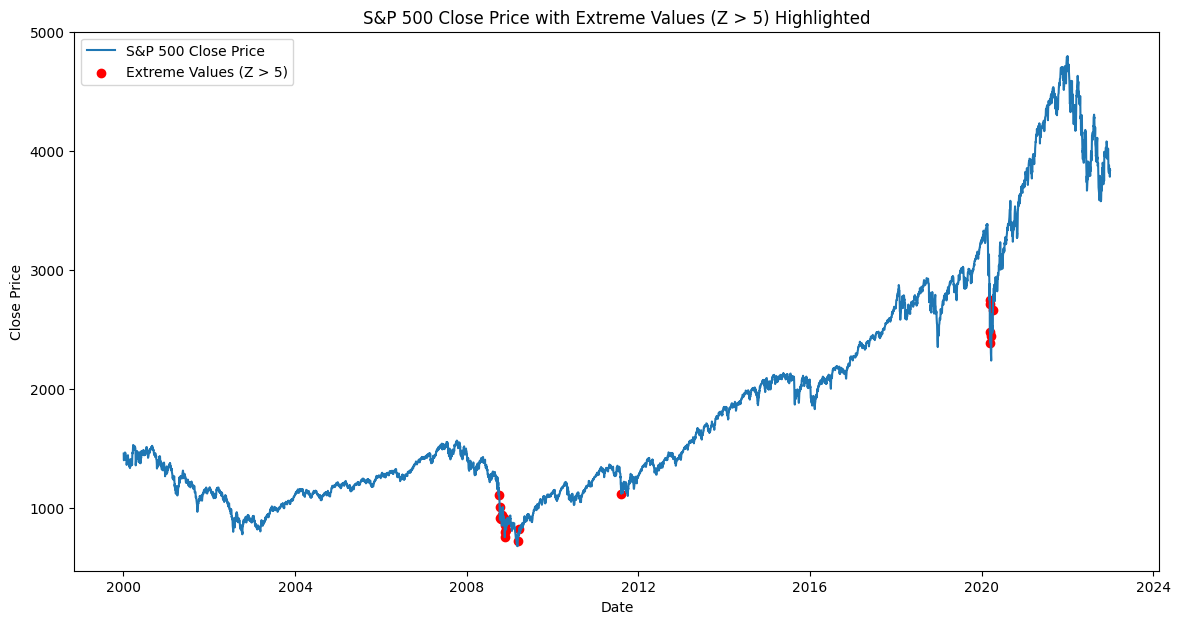

In [25]:
# Calculate daily returns
sp500_data['Returns'] = sp500_data['Close'].pct_change()

# Calculate the mean and standard deviation of daily returns
mean_returns = sp500_data['Returns'].mean()
std_returns = sp500_data['Returns'].std()

# Calculate the Z-score of the daily returns
sp500_data['Z-Score'] = (sp500_data['Returns'] - mean_returns) / std_returns

# Define a function to identify extreme movements based on Z-score threshold
def identify_extremes(data, threshold):
    return data[np.abs(data['Z-Score']) > threshold]

# Define Z-score thresholds for sensitivity analysis
thresholds = [1, 2, 3, 4, 5]  

# Conduct sensitivity analysis
extreme_values_dict = {}
for threshold in thresholds:
    extreme_values = identify_extremes(sp500_data, threshold)
    extreme_values_dict[threshold] = extreme_values
    print(f"Threshold {threshold}: {len(extreme_values)} extreme values")

# Plot each threshold
for threshold, extreme_values in extreme_values_dict.items():
    plt.figure(figsize=(14, 7))
    plt.plot(sp500_data.index, sp500_data['Close'], label='S&P 500 Close Price')
    plt.scatter(extreme_values.index, extreme_values['Close'], color='red', label=f'Extreme Values (Z > {threshold})')
    plt.title(f'S&P 500 Close Price with Extreme Values (Z > {threshold}) Highlighted')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()


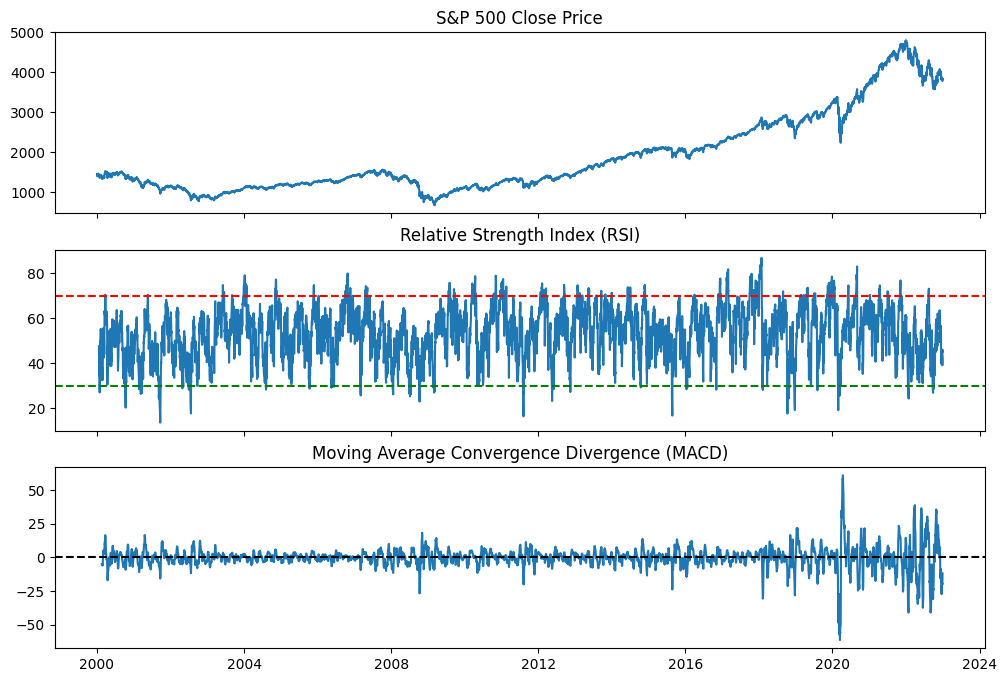

RSI Stats: Avg Gain, Median Gain, Max Gain, Avg Loss, Median Loss, Max Loss
(6.814663242221346, 7.047578676724847, 10.328194987251885, -3.6952612232980147, -2.0806290109044374, -14.00028434072052)
MACD Stats: Avg Gain, Median Gain, Max Gain, Avg Loss, Median Loss, Max Loss
(3.16250428647972, 2.2524728127984055, 15.83237697441099, -3.8000812260151826, -2.27902812487821, -33.41699509681333)


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

# Calculate MACD
sp500_data['macd'] = ta.trend.macd_diff(sp500_data['Close'])

# Generate buy/sell signals for MACD
sp500_data['macd_signal'] = np.where(sp500_data['macd'] > 0, 1, 0)
sp500_data['macd_buy'] = sp500_data['macd_signal'].diff() > 0
sp500_data['macd_sell'] = sp500_data['macd_signal'].diff() < 0

# Calculate RSI
sp500_data['rsi'] = ta.momentum.rsi(sp500_data['Close'], window=14)

# Generate buy/sell signals for RSI
sp500_data['rsi_buy'] = np.where(sp500_data['rsi'] < 30, 1, 0)
sp500_data['rsi_sell'] = np.where(sp500_data['rsi'] > 70, 1, 0)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12,8))

# Price
ax1.plot(sp500_data['Close'])
ax1.set_title('S&P 500 Close Price')

# RSI
ax2.plot(sp500_data['rsi'])
ax2.axhline(70, color='red', linestyle='--')
ax2.axhline(30, color='green', linestyle='--')
ax2.set_title('Relative Strength Index (RSI)')

# MACD
ax3.plot(sp500_data['macd'], label='MACD Line')
ax3.axhline(0, color='black', linestyle='--')
ax3.set_title('Moving Average Convergence Divergence (MACD)')

plt.show()

# Calculate statistics function
def calculate_statistics(data, buy_signal, sell_signal):
    max_gains = []
    max_losses = []
    buy_price = None
    sell_price = None

    for i in range(1, len(data)):
        # Buy signal
        if data[buy_signal].iloc[i]:
            if buy_price is None:  # Only update if we don't already have a buy position
                buy_price = data['Close'].iloc[i]
                max_price_after_buy = data['Close'].iloc[i]  # Initialize max price after buy

        # Sell signal
        elif data[sell_signal].iloc[i]:
            if sell_price is None:  # Only update if we don't already have a sell position
                sell_price = data['Close'].iloc[i]
                min_price_after_sell = data['Close'].iloc[i]  # Initialize min price after sell

        # If there is a buy signal without a sell signal
        if buy_price is not None and sell_price is None:
            max_price_after_buy = max(max_price_after_buy, data['Close'].iloc[i])

        # If there is a sell signal without a buy signal
        elif sell_price is not None and buy_price is None:
            min_price_after_sell = min(min_price_after_sell, data['Close'].iloc[i])

        # If there is a new sell signal after a buy signal
        if buy_price is not None and data[sell_signal].iloc[i]:
            max_gain = (max_price_after_buy - buy_price) / buy_price * 100
            max_gains.append(max_gain)
            buy_price = None  # Reset buy_price

        # If there is a new buy signal after a sell signal
        if sell_price is not None and data[buy_signal].iloc[i]:
            max_loss = (sell_price - min_price_after_sell) / sell_price * 100
            max_losses.append(max_loss)  
            sell_price = None  # Reset sell_price

    # Filter gains and losses
    filtered_gains = [gain for gain in max_gains if gain > 0]
    filtered_losses = [-loss for loss in max_losses if loss > 0]  # Convert to negative for differentiation

    # Calculate statistics
    avg_max_gain = np.mean(filtered_gains) if filtered_gains else 0
    avg_max_loss = np.mean(filtered_losses) if filtered_losses else 0

    median_max_gain = np.median(filtered_gains) if filtered_gains else 0
    median_max_loss = np.median(filtered_losses) if filtered_losses else 0

    max_gain = np.max(filtered_gains) if filtered_gains else 0
    max_loss = np.min(filtered_losses) if filtered_losses else 0  # Use min because losses are negative

    return avg_max_gain, median_max_gain, max_gain, avg_max_loss, median_max_loss, max_loss


# Calculate statistics for RSI
rsi_stats = calculate_statistics(sp500_data, 'rsi_buy', 'rsi_sell')
print("RSI Stats: Avg Gain, Median Gain, Max Gain, Avg Loss, Median Loss, Max Loss")
print(rsi_stats)

# Calculate statistics for MACD
macd_stats = calculate_statistics(sp500_data, 'macd_buy', 'macd_sell')
print("MACD Stats: Avg Gain, Median Gain, Max Gain, Avg Loss, Median Loss, Max Loss")
print(macd_stats)
